In [1]:
#############################################################
# Author(s): Debaditya, Anwesha, Anna                       #
#############################################################

In [2]:
#Download the data files.

import os, requests

fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
                    
#Setup dependencies

#Dependencies:
#numpy
#matplotlib

import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

rcParams['figure.figsize'] = [16, 10]
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

#Groupings of brain regions

regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]
brain_groups_all = brain_groups[:]
n_regions = len(regions)

#Load the data

def load_alldat():
    alldat = np.array([])
    for j in range(len(fname)):
        alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))
    return alldat

alldat = load_alldat()
dt = alldat[0]['bin_size']

# Garbage collection
import gc
gc.collect()

16

In [3]:
brain_groups_all = list(np.hstack(brain_groups))
print(len(brain_groups_all))

72


In [4]:
for key in alldat[0].keys():
    print(key)

spks
wheel
pupil
response
response_time
bin_size
stim_onset
contrast_right
contrast_left
brain_area
feedback_time
feedback_type
gocue
mouse_name
date_exp
trough_to_peak
active_trials
contrast_left_passive
contrast_right_passive
spks_passive
pupil_passive
wheel_passive
prev_reward
ccf
ccf_axes
cellid_orig
reaction_time
face
face_passive
licks
licks_passive


In [5]:
#Generate some metadata for the neuron regions.

def generate_metadata(dat):
    n_neurons = (len(dat['brain_area']))
    n_regions = len(regions)
    region_index = np.zeros(n_neurons)
    group_index = np.zeros(n_neurons)
    for region in range(len(regions)-1):
        region_index[np.isin(dat['brain_area'], brain_groups[region])] = region
    for group in range(len(brain_groups_all)):
        group_index[np.where(dat['brain_area']==brain_groups_all[group])[0]] = group
    return n_neurons, region_index, group_index

In [6]:
np.shape(alldat[0]['spks'])

(734, 214, 250)

In [7]:
#Choose dataset
session =11
dat = alldat[session]
dt = dat['bin_size']
no_of_bins = np.shape(dat['spks'])[2]
n_neurons, region_index, group_index = generate_metadata(dat)
spikes_all = dat['spks']
spikes_passive = dat['spks_passive']
groups_present = np.unique(dat['brain_area'])
n_group_present = len(np.unique(dat['brain_area']))

CR_idx = np.where(dat['feedback_type']==1)[0]
WR_idx = np.where(dat['feedback_type']==-1)[0]
spikes_CR = dat['spks'][:, CR_idx, :]
spikes_WR = dat['spks'][:, WR_idx, :]

In [8]:
print(np.unique(group_index))

[ 0.  1.  3.  8.  9. 11. 23. 26. 27. 29. 35. 40.]


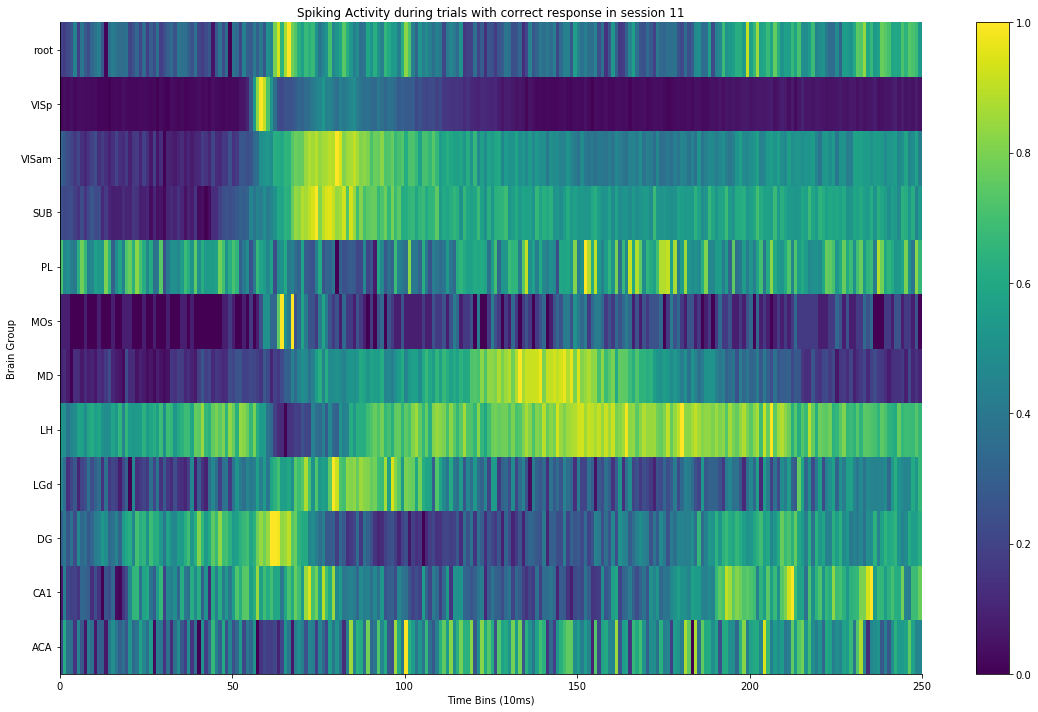

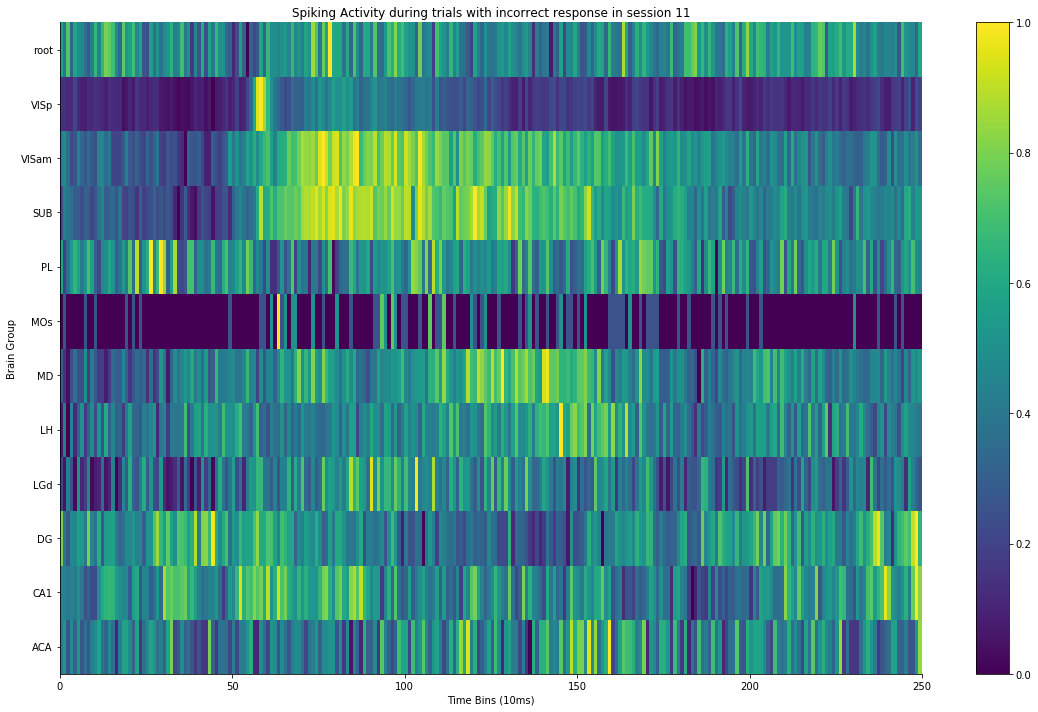

In [9]:
group_activation_CR = np.zeros((n_group_present, no_of_bins))
group_activation_WR = np.zeros((n_group_present, no_of_bins))
for idx, group in enumerate(groups_present):
    CR_spikes = np.mean(spikes_CR[np.where(dat['brain_area'] == group)[0],:,:],axis=(0,1))#/np.mean(spikes_passive[np.where(dat['brain_area'] == group)[0],:,:],axis=(0,1,2))
    WR_spikes = np.mean(spikes_WR[np.where(dat['brain_area'] == group)[0],:,:],axis=(0,1))#/np.mean(spikes_passive[np.where(dat['brain_area'] == group)[0],:,:],axis=(0,1,2))
    
    #Normalize
    CR_spikes = (CR_spikes - np.min(CR_spikes))/np.ptp(CR_spikes)
    WR_spikes = (WR_spikes - np.min(WR_spikes))/np.ptp(WR_spikes)
    
    group_activation_CR[idx,:] = CR_spikes
    group_activation_WR[idx,:] = WR_spikes

plt.pcolormesh(group_activation_CR)
plt.yticks(np.arange(0.5,len(groups_present),1),groups_present)
plt.ylabel('Brain Group')
plt.xlabel('Time Bins (10ms)')
plt.title('Spiking Activity during trials with correct response in session '+str(session))
plt.colorbar()
plt.show()
plt.pcolormesh(group_activation_WR)
plt.yticks(np.arange(0.5,len(groups_present),1),groups_present)
plt.ylabel('Brain Group')
plt.xlabel('Time Bins (10ms)')
plt.title('Spiking Activity during trials with incorrect response in session '+str(session))
plt.colorbar()
plt.show()

In [13]:
import scipy as sp
group_activation_CR = np.zeros((n_group_present, no_of_bins))
group_activation_CR_tr = []
group_activation_WR = np.zeros((n_group_present, no_of_bins))
group_activation_WR_tr = []
for idx, group in enumerate(groups_present):
    group_activation_CR_tr.append([])
    group_activation_WR_tr.append([])
    CR_spikes = np.mean(spikes_CR[np.where(dat['brain_area'] == group)[0],:,:],axis=(0,1))#/np.mean(spikes_passive[np.where(dat['brain_area'] == group)[0],:,:],axis=(0,1,2))
    WR_spikes = np.mean(spikes_WR[np.where(dat['brain_area'] == group)[0],:,:],axis=(0,1))#/np.mean(spikes_passive[np.where(dat['brain_area'] == group)[0],:,:],axis=(0,1,2))
    
    #Smooth the data
    CR_spikes = sp.signal.savgol_filter(CR_spikes,5,3)
    WR_spikes = sp.signal.savgol_filter(WR_spikes,5,3)
    #Normalize
    CR_spikes = (CR_spikes - np.min(CR_spikes))/np.ptp(CR_spikes)
    
    group_activation_CR_tr[idx] = np.where(CR_spikes>(CR_spikes.mean()+1.96*CR_spikes.std()))[0]
    
    group_activation_CR[idx,:] = CR_spikes
    group_activation_WR[idx,:] = WR_spikes

plt.pcolormesh(group_activation_CR/dt)
#     WR_spikes = (WR_spikes - np.min(WR_spikes))/np.ptp(WR_spikes)
for idx in range(len(groups_present)):
    plt.plot(group_activation_CR_tr[idx],np.ones(len(group_activation_CR_tr[idx]))*(0.5+idx),'r.')
plt.yticks(np.arange(0.5,len(groups_present),1),groups_present)
plt.ylabel('Brain Group')
plt.xlabel('Time Bins (10ms)')
plt.title('Spiking Activity during trials with correct response in session '+str(session))
plt.colorbar()
plt.show()
plt.pcolormesh(group_activation_WR)
plt.yticks(np.arange(0.5,len(groups_present),1),groups_present)
plt.ylabel('Brain Group')
plt.xlabel('Time Bins (10ms)')
plt.title('Spiking Activity during trials with incorrect response in session '+str(session))
plt.colorbar()
plt.show()

AttributeError: module 'scipy' has no attribute 'signal'

In [14]:
#Choose dataset
session = 11
dat = alldat[session]
dt = dat['bin_size']
n_neurons, n_trials, no_of_bins = np.shape(dat['spks'])
n_neurons, region_index, group_index = generate_metadata(dat)
spikes_all = dat['spks']
spikes_passive = dat['spks_passive']
groups_present = np.unique(dat['brain_area'])
n_group_present = len(np.unique(dat['brain_area']))

CR_idx = np.where(dat['feedback_type']==1)[0]
WR_idx = np.where(dat['feedback_type']==-1)[0]
spikes_CR = dat['spks'][:, CR_idx, :]
spikes_WR = dat['spks'][:, WR_idx, :]

In [15]:
#Lets build a linear classifier!
from sklearn import linear_model
spikes_CR_groups = np.zeros((n_group_present,np.shape(spikes_CR)[1],np.shape(spikes_CR)[2]))
for idx, group in enumerate(groups_present):
    spikes_CR_groups[idx] = np.mean(spikes_CR[np.where(dat['brain_area']==group)[0]])

np.random.seed(2020)
X_train = np.vstack((spikes_CR_groups[4,:200,:],spikes_CR_groups[10,:200,:]))
y_train = np.vstack((np.ones((200,1))*4,np.ones((200,1))*10))
random_train = np.random.permutation(400)
print(np.shape(X_train),np.shape(y_train))
X_train = X_train[random_train]
y_train = y_train[random_train]

X_test = np.vstack((spikes_CR_groups[4,200:,:],spikes_CR_groups[10,200:,:]))
y_test = np.vstack((np.ones((51,1))*4,np.ones((51,1))*10))
random_test = np.random.permutation(102)
X_test = X_test[random_test]
y_test = y_test[random_test]
print(np.shape(X_train),np.shape(X_test))

classifer_model = linear_model.Ridge(alpha=0.5)

classifer_model.fit(X_train,y_train)

(400, 250) (400, 1)
(400, 250) (102, 250)


Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [16]:
print("R value of classifier on train data:",classifer_model.score(X_train,y_train))
print("R value of classifier on test data:",classifer_model.score(X_test,y_test))
classifer_model.predict(np.reshape(X_test[4,:],(1,-1)))
print(10)

R value of classifier on train data: 0.9999977367669917
R value of classifier on test data: 0.9999977367669917
10


In [ ]:
CR_trials = np.shape(spikes_CR)[2]

X = np.array(spikes_CR[:,0,:])
y = np.reshape(np.array(group_index),(-1,1))
for trial in range(1,CR_trials):
    X = np.vstack((X,spikes_CR[:,trial,:]))
    y = np.vstack((y,y))

In [ ]:
print(np.shape(X),np.shape(y))